In [2]:
from densitypy.project_utils.daskloading import fetch_csv_data_dask


In [10]:
EXPERIMENT_PATH = "/home/ruben/PycharmProjects/DensityPy/Studies/ExampleStudy/debug_sim"
atomic_charege_file_path = f'{EXPERIMENT_PATH}/AtomicCharge/AtomicCharge_ALL.csv'

data = fetch_csv_data_dask(data_file_path=atomic_charege_file_path)

In [3]:
data.head()

,itime,iSim,Atom_O_ChargeX,Atom_O_ChargeY,Atom_O_ChargeZ,Atom_N_ChargeX,Atom_N_ChargeY,Atom_N_ChargeZ,Atom_C_ChargeX,Atom_C_ChargeY,...,Atom_H_ChargeZ.3,Atom_H_ChargeX.4,Atom_H_ChargeY.4,Atom_H_ChargeZ.4,Atom_H_ChargeX.5,Atom_H_ChargeY.5,Atom_H_ChargeZ.5,Atom_H_ChargeX.6,Atom_H_ChargeY.6,Atom_H_ChargeZ.6
0,-5000.000000,1.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,-4996.000889,1.0,0.0,-3.338422e-13,0.0,3.256133e-14,-2.279970e-14,0.0,0.0,0.0,...,-1.177345e-13,-1.767926e-13,-2.033745e-13,1.177640e-13,-4.225375e-13,-7.142637e-14,1.377618e-13,-4.225615e-13,-7.142622e-14,-1.377720e-13
2,-4992.001777,1.0,0.0,-6.685389e-13,0.0,6.503925e-14,-4.554100e-14,0.0,0.0,0.0,...,-2.352951e-13,-3.532956e-13,-4.064160e-13,2.353351e-13,-8.453014e-13,-1.428910e-13,2.755973e-13,-8.452986e-13,-1.428821e-13,-2.756013e-13
3,-4988.002666,1.0,0.0,-1.002686e-12,0.0,9.750988e-14,-6.827718e-14,0.0,0.0,0.0,...,-3.528015e-13,-5.296904e-13,-6.093329e-13,3.528341e-13,-1.267642e-12,-2.142841e-13,4.132948e-13,-1.267573e-12,-2.142598e-13,-4.132797e-13
4,-4984.003555,1.0,0.0,-1.334883e-12,0.0,1.300289e-13,-9.104728e-14,0.0,0.0,0.0,...,-4.703423e-13,-7.061209e-13,-8.122910e-13,4.703570e-13,-1.688847e-12,-2.854852e-13,5.506223e-13,-1.688683e-12,-2.854407e-13,-5.505785e-13


In [72]:
# keep iTime as the index, iSim as the columns and the rest as the values meaning the we need to add an atom_id column to differenciated between the atoms, as the names of these id you can use the columns names. right now the columns are "itime","iSim","Atom_O_ChargeX","Atom_O_ChargeY","Atom_O_ChargeZ","Atom_N_ChargeX","Atom_N_ChargeY","Atom_N_ChargeZ","Atom_C_ChargeX","Atom_C_ChargeY","Atom_C_ChargeZ","Atom_C_ChargeX","Atom_C_ChargeY","Atom_C_ChargeZ","Atom_C_ChargeX","Atom_C_ChargeY","Atom_C_ChargeZ","Atom_H_ChargeX","Atom_H_ChargeY","Atom_H_ChargeZ","Atom_H_ChargeX","Atom_H_ChargeY","Atom_H_ChargeZ","Atom_H_ChargeX","Atom_H_ChargeY","Atom_H_ChargeZ","Atom_H_ChargeX","Atom_H_ChargeY","Atom_H_ChargeZ","Atom_H_ChargeX","Atom_H_ChargeY","Atom_H_ChargeZ","Atom_H_ChargeX","Atom_H_ChargeY","Atom_H_ChargeZ","Atom_H_ChargeX","Atom_H_ChargeY","Atom_H_ChargeZ"

# Assuming df is your original DataFrame
# Separate 'iTime' and 'iSim' from the rest of the columns
atom_columns = [col for col in data.columns if col not in ['itime', 'iSim']]

# Melt the DataFrame to long format
melted_df = data.melt(id_vars=['itime', 'iSim'], var_name='atom_info', value_name='value')

In [76]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# Assuming df is your original DataFrame

def prep_atom_column(atom_column_name):
    atom_info = atom_column_name.split("_")
    atom_name = "_".join(atom_info[:2]).removeprefix('Atom_')
    axis = atom_info[2].removeprefix('Charge')
    atom_info_split_by_dot = axis.split(".")

    if len(atom_info_split_by_dot) == 1:
        atom_repetition_id = "0"
    else:
        atom_repetition_id = atom_info_split_by_dot[-1]

    axis = axis.replace(f'.{atom_repetition_id}', '')
    atom_id = atom_name + atom_repetition_id
    return atom_id, axis

# Melt the DataFrame to long format
melted_df = data.melt(id_vars=['itime', 'iSim'], var_name='atom_info', value_name='value')

# Define a function to process a chunk of the DataFrame
def process_chunk(chunk):
    return chunk['atom_info'].apply(prep_atom_column)

# Split the DataFrame into chunks for parallel processing
chunks = np.array_split(melted_df, 10)

# Process each chunk in parallel
with ThreadPoolExecutor(max_workers=28) as executor:
    results = executor.map(process_chunk, chunks)

# Combine the results back into a single DataFrame
combined_results = pd.concat(results)

# Assign the results to the appropriate columns in the melted DataFrame
melted_df[['iAtom', 'axis']] = pd.DataFrame(combined_results.tolist(), index=melted_df.index)

# The final DataFrame is now in the desired format: iSim, iTime, iAtom, axis, value
final_df = melted_df[['iSim', 'itime', 'iAtom', 'axis', 'value']]

/home/ruben/anaconda3/envs/DensityPy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [77]:
final_df

,iSim,itime,iAtom,axis,value
0,1.0,-5000.000000,O0,X,0.000000
1,1.0,-4996.000889,O0,X,0.000000
2,1.0,-4992.001777,O0,X,0.000000
3,1.0,-4988.002666,O0,X,0.000000
4,1.0,-4984.003555,O0,X,0.000000
...,...,...,...,...,...
40671031,251.0,12980.004443,H6,Z,-0.000085
40671032,251.0,12984.003555,H6,Z,-0.000085
40671033,251.0,12988.002666,H6,Z,-0.000085
40671034,251.0,12992.001777,H6,Z,-0.000085


In [ ]:
final_df.to_csv(f'{EXPERIMENT_PATH}/AtomicCharge/AtomicCharge_ALL_melted.csv', index=False)

## Data Exploration

In [3]:
from densitypy.project_utils.daskloading import fetch_csv_data_dask

EXPERIMENT_PATH = "/home/ruben/PycharmProjects/DensityPy/Studies/ExampleStudy/debug_sim"
atomic_charege_file_path = f'{EXPERIMENT_PATH}/AtomicCharge/AtomicCharge_ALL_melted.csv'
melted_data = fetch_csv_data_dask(data_file_path=atomic_charege_file_path)

In [4]:
melted_data.head(10)

,iSim,itime,iAtom,axis,value
0,1.0,-5000.000000,O0,X,0.0
1,1.0,-4996.000889,O0,X,0.0
2,1.0,-4992.001777,O0,X,0.0
3,1.0,-4988.002666,O0,X,0.0
4,1.0,-4984.003555,O0,X,0.0
5,1.0,-4980.004443,O0,X,0.0
6,1.0,-4976.005332,O0,X,0.0
7,1.0,-4972.006221,O0,X,0.0
8,1.0,-4968.007110,O0,X,0.0
9,1.0,-4964.007998,O0,X,0.0


In [5]:
# Read data from download folder
import pandas as pd
import torch
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping
import seaborn as sns 
from matplotlib import pyplot as plt


/home/ruben/anaconda3/envs/DensityPy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_394999/2451003862.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=melted_data, x='value', hue='iAtom', fill=True, alpha=0.2, ax=ax,thresh=0.0001)


(0.0, 800.0)

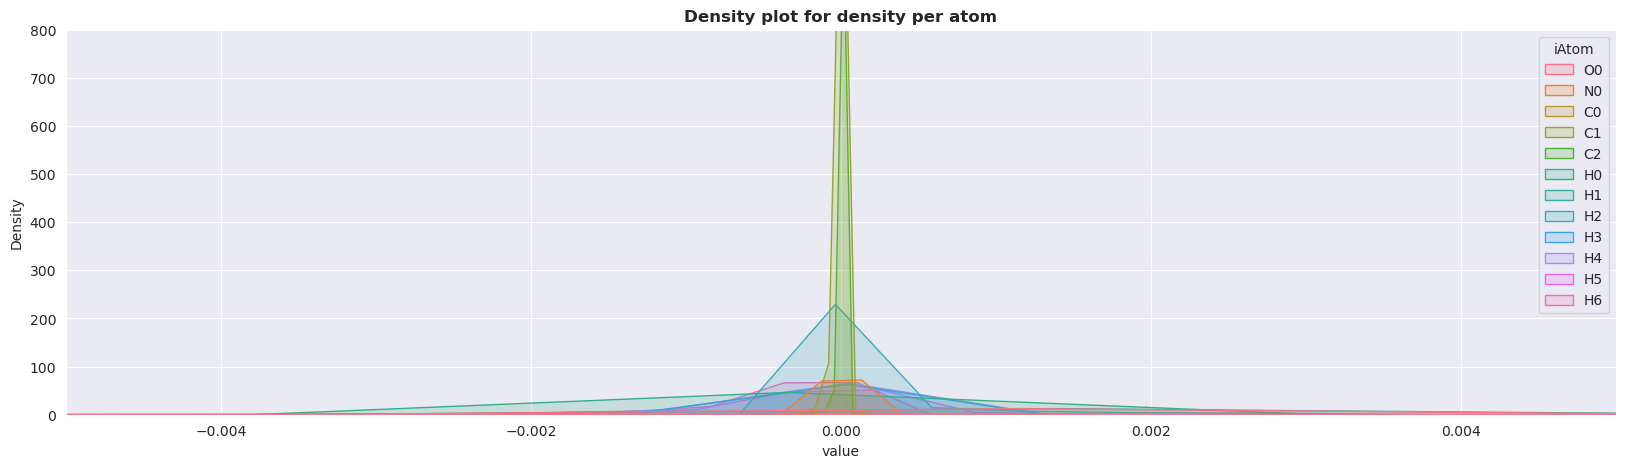

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

sns.kdeplot(data=melted_data, x='value', hue='iAtom', fill=True, alpha=0.2, ax=ax,thresh=0.0001)
ax.set_title('Density plot for density per atom', fontweight='bold')
ax.set_xlim([-0.005,0.005])
ax.set_ylim([0,800])


<Axes: title={'center': 'value'}, xlabel='[iAtom, axis]'>

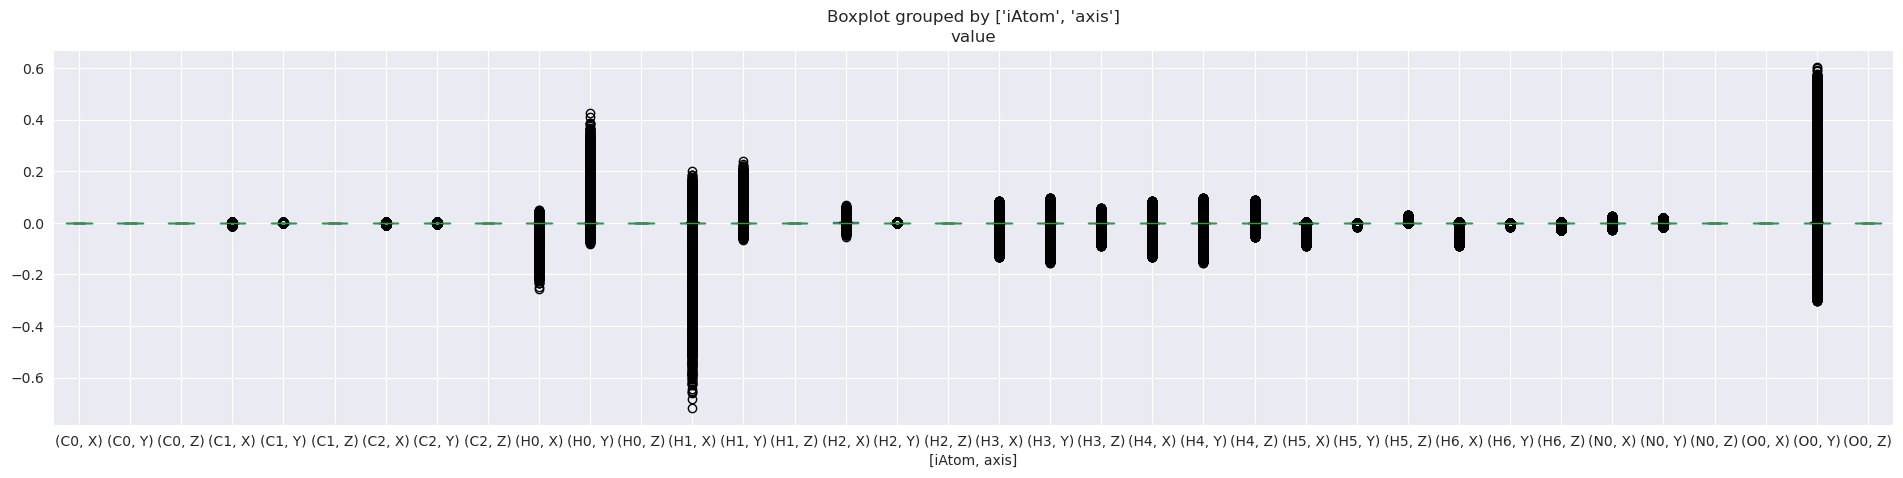

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(23, 5))
melted_data[["iAtom","axis", "value"]].boxplot(by=["iAtom","axis"], ax=ax)
